# Library Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)

# Getting the emotion values of the lyrics

In [ ]:
# load the cleaned lyrics data
cleaned_lyrics = pd.read_csv('datasets/lyrics_data_cleaned.csv')
print(cleaned_lyrics.columns)
print(cleaned_lyrics.shape)

Index(['track_id', 'title_genius', 'artist_genius', 'title_spotify',
       'artist_spotify', 'lyrics', 'cleaned_lyrics', 'num_words',
       'num_sentences'],
      dtype='object')
(2374, 9)


In [ ]:
# let's get only lyrics with more than 20 words (since if the lyrics is less than 20 words, there aren't much information for the transformer to use)
# and also get only the columns that we need
song_lyrics = cleaned_lyrics[cleaned_lyrics['num_words'] > 20][['track_id', 'cleaned_lyrics']]

In [ ]:
song_lyrics.sample(5)

,track_id,cleaned_lyrics
704,2GgBtBIiCiHtSFeYkUC6LU,"When I'm with you, babe\nI think you know what..."
1122,4w2sOKmotzKsdGDLHic94B,I wanna smash your fears\nAnd get drunken off ...
635,2Ig68x4WLnTHjaxIKfwz3H,I'm going outside\nOut-out-out-out-out-out-out...
2320,0tMMPZEt6Gyrl9FI8zSicm,I've never known someone like you\nTangled in ...
1659,7B3z0ySL9Rr0XvZEAjWZzM,I think we could do it if we tried\nIf only to...


Here, I'm going to use [
Emotion English DistilRoBERTa-base](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base) to classify the emotion in the lyrics, we need to do some additional preprocessing for the text data

In [4]:
# let's prep the lyrics
import re

In [ ]:
# option 1 : remove all carriage returns and newlines into a space
song_lyrics['cleaned_lyrics'] = song_lyrics['cleaned_lyrics'].apply(lambda x: re.sub(r'[\r\n]+', ' ', x))

In [ ]:
# option 2 : convert the carriage returns and newlines into a newline
song_lyrics['cleaned_lyrics'] = song_lyrics['cleaned_lyrics'].apply(lambda x: re.sub(r'[\r\n]+', '\n', x))

In [ ]:
# and use langdetect to detect the language of the lyrics, this will filter out non-english lyrics
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

def is_english(lyrics):
    try:
        return detect(lyrics) == 'en'
    except:
        return False

In [ ]:
song_lyrics['is_english'] = song_lyrics['cleaned_lyrics'].apply(is_english)

In [ ]:
song_lyrics['is_english'].value_counts()

is_english
True     1858
False     446
Name: count, dtype: int64

In [ ]:
# filter out the non-english lyrics
english_song_lyrics = song_lyrics[song_lyrics['is_english']]

In [ ]:
english_song_lyrics.sample(5)

,track_id,cleaned_lyrics,is_english
19,1x59YtDtw7jPZTxqNYmhq2,"Say the words, even if it hurts We’ve been pre...",True
1337,4G51VBbTXI30VZ5KSXYmcG,I'm exhausted from trying my hardest You're ta...,True
331,7aOcwgkkRYqj6cVdpPtDQB,(Flight? Flight?) Step through the gate into u...,True
1437,1dtTRXifeGC51adYy0902s,"Ayy, uh-huh Yeah, I'm a bad boy doin' good thi...",True
1456,2U42jVkNgEU6DoM64eFD7i,What are you going to do when Hip-Hop goes out...,True


## Using RoBERTa to classify the emotions in the lyrics

In [ ]:
# import the libraries
import transformers
import torch

In [ ]:
from transformers import pipeline

# Initialize the emotion analysis pipeline with a pre-trained model
emotion_analyzer = pipeline("text-classification", 
                            model="j-hartmann/emotion-english-distilroberta-base",
                            top_k=None)

i:\Projects\my-spotify-usage-analysis\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# since the lyrics might be too long, we need to split it into chunks of 512 tokens
# option 1 : split the lyrics into chunks of 512 tokens using RobertaTokenizer
def split_text(text, max_length=510): # here it's 510 because the 2 tokens are used for the special token <s> and </s>
    from transformers import RobertaTokenizer

    tokenizer = RobertaTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_length):
        chunk = tokenizer.convert_tokens_to_string(tokens[i:i + max_length])
        chunks.append(chunk)
    return chunks

In [ ]:
# option 2: split the lyrics based on newline
def split_text_newline(text):
    chunks = text.split('\n')
    return chunks

In [ ]:
# then aggregate the emotion scores of each chunk to get the overall emotion scores of the lyrics
from collections import defaultdict

def aggregate_emotions(chunks, analyzer):
    emotion_totals = defaultdict(float)
    for chunk in chunks:
        emotions = analyzer(chunk)
        for emotion in emotions[0]:
            emotion_totals[emotion['label']] += emotion['score']
    # Normalize the scores
    total = sum(emotion_totals.values())
    for emotion in emotion_totals:
        emotion_totals[emotion] /= total
    return emotion_totals

In [ ]:
# get the emotion of each rows from english_song_lyrics
emotions = ['anger', 'joy', 'disgust', 'sadness', 'surprise', 'fear', 'neutral']

# for each row, analyze the emotions
for row in english_song_lyrics.itertuples():
    lyrics_chunk = split_text(row.cleaned_lyrics)
    emotion_totals = aggregate_emotions(lyrics_chunk, emotion_analyzer)
    for emotion in emotions:
        english_song_lyrics.loc[row.Index, emotion] = emotion_totals.get(emotion, 0)
    english_song_lyrics.loc[row.Index, 'dominant_emotion'] = max(emotion_totals, key=emotion_totals.get)

In [ ]:
# let's see the results
for emotion in emotions:
    print(emotion)
    display(english_song_lyrics[english_song_lyrics['dominant_emotion'] == emotion].sample(5))

anger


,track_id,cleaned_lyrics,is_english,anger,joy,disgust,sadness,surprise,fear,neutral,dominant_emotion
3,05LCfd8s9n2teUcsTsBAnr,"K-K-Kato on the track, bitch I prayed for my e...",True,0.518257,0.004554,0.010931,0.009387,0.005737,0.429916,0.021217,anger
15,2bfGNzdiRa1jXZRdfssSzR,I need a gun to keep myself among Poor people ...,True,0.900115,0.004712,0.014777,0.032569,0.003804,0.011370,0.032654,anger
25,5HOpkTTVcmZHnthgyxrIL8,"Dog goes ""woof"", cat goes ""meow"" Bird goes ""tw...",True,0.305826,0.089152,0.047945,0.053611,0.274916,0.075339,0.153210,anger
26,59PCsXjyZnAzDTOyC4QdZx,My life is so successful I've got everything a...,True,0.426186,0.025895,0.083694,0.037101,0.370855,0.022410,0.033859,anger
30,5Fm1OwRebHb5GFwdT3ia89,You've got a hold on me Don't even know your p...,True,0.313935,0.007987,0.043316,0.086719,0.042441,0.259984,0.245618,anger


joy


,track_id,cleaned_lyrics,is_english,anger,joy,disgust,sadness,surprise,fear,neutral,dominant_emotion
36,271feX4Fipo7wGlxTYqjQa,Cause any moment is a memory of A lifetime A l...,True,0.015497,0.877158,0.001307,0.009790,0.035015,0.007360,0.053873,joy
52,0afhq8XCExXpqazXczTSve,She played the fiddle in an Irish band But she...,True,0.097014,0.325057,0.155557,0.071876,0.145032,0.057495,0.147969,joy
56,0KKkJNfGyhkQ5aFogxQAPU,"Ayy, ayy, ayy I got a condo in Manhattan Baby ...",True,0.082933,0.409846,0.014622,0.017466,0.088092,0.005383,0.381658,joy
66,3TJk0aoXM0knrOlgd1fnbx,"""No thank you"" is what I should've said I shou...",True,0.099152,0.264523,0.033096,0.181023,0.079116,0.171553,0.171537,joy
80,2RttW7RAu5nOAfq6YFvApB,Walkin' down th and Park I saw you in another'...,True,0.007935,0.770841,0.005054,0.070808,0.040787,0.001675,0.102900,joy


disgust


,track_id,cleaned_lyrics,is_english,anger,joy,disgust,sadness,surprise,fear,neutral,dominant_emotion
49,01LSU6meTykNfXu66aBTvZ,I have a small dick I have a small dick If you...,True,0.037787,0.006075,0.698535,0.052354,0.085004,0.043549,0.076695,disgust
116,600wewdSes7BMxXmm6UD7M,"You're never gonna love me Friend, what's the ...",True,0.104148,0.051094,0.316362,0.068526,0.041547,0.115843,0.302480,disgust
126,167NczpNbRF7oWakJaY3Hh,"(Woo) ""We should take this back to my place"" T...",True,0.151452,0.027655,0.288549,0.200919,0.024540,0.090057,0.216827,disgust
209,15Uxmx6D6hW0gY5kc7bpqU,"Dream Addix Yo, I wasn't about to go in but li...",True,0.312899,0.012878,0.340313,0.083955,0.080792,0.089568,0.079595,disgust
276,22Je85Q7fw8oVDRIHiv4z3,"Yeah, woo, yeah, skrrt M-M-M-Murda Motorsport,...",True,0.092837,0.040324,0.280464,0.080926,0.067337,0.247977,0.190135,disgust


sadness


,track_id,cleaned_lyrics,is_english,anger,joy,disgust,sadness,surprise,fear,neutral,dominant_emotion
2,4VrdksXJVhAOLW49qV0VTQ,: Lets Be Friends - Manslaughter (VIP Mix) : R...,True,0.007728,0.234411,0.005014,0.408969,0.069162,0.005751,0.268964,sadness
9,2kBR8dkyKfd25W9PRUFrLh,"They say the sky is the limit, well I've passe...",True,0.180846,0.028052,0.188432,0.298278,0.022736,0.032466,0.249190,sadness
11,4mKaGkUNWrbDtvTl7sZDkt,I'm shifting my mind to get around you Still h...,True,0.011929,0.015484,0.005592,0.782397,0.016941,0.035698,0.131958,sadness
14,48qF1yaxtfOga12D6xR0Im,I'm so alone Nothing feels like home I'm so al...,True,0.001837,0.000890,0.001657,0.970361,0.007111,0.011183,0.006961,sadness
16,26ZC396ABpfS0MIbOetGEV,Endless sun as the days go on forever There's ...,True,0.012655,0.016152,0.014994,0.682287,0.051584,0.107501,0.114826,sadness


surprise


,track_id,cleaned_lyrics,is_english,anger,joy,disgust,sadness,surprise,fear,neutral,dominant_emotion
17,6rn7zSeV46JMH0hJa4JJ6O,I think I'm finally giving in I'll let our lov...,True,0.020876,0.245429,0.003478,0.133738,0.389053,0.011493,0.195933,surprise
21,51O58Axxs6CFiJzf1uUflq,Lay down staring at the sunset And I wonder ho...,True,0.013607,0.003473,0.005737,0.022401,0.878219,0.046486,0.030077,surprise
34,7wIkCYvFL159wjEDRn4qWI,"Ooh, ooh, ooh, ooh Ooh, ooh, ooh, ooh Ooh, ooh...",True,0.154011,0.010403,0.029370,0.118115,0.409086,0.097723,0.181291,surprise
44,3JaKlOxGyK5S38uI2YabYn,I wonder if he know that I know he's lying rig...,True,0.289516,0.012502,0.240103,0.057075,0.318307,0.058588,0.023909,surprise
50,7rE9wYXPgLqZsXVxn2JhU9,"Uh, what? What? What? What? I'm a large pink c...",True,0.141702,0.026195,0.257142,0.030854,0.453450,0.039648,0.051010,surprise


fear


,track_id,cleaned_lyrics,is_english,anger,joy,disgust,sadness,surprise,fear,neutral,dominant_emotion
0,4mjgNE8R31AzxWfPNGtVMf,:: RIOT - Blackwater :: Pixel Terror - Amnesia...,True,0.051847,0.037984,0.012398,0.302720,0.033707,0.389428,0.171916,fear
13,15O20RQyWJgKrkHID9ynT9,What I would do to take away This fear of bein...,True,0.404438,0.010647,0.038302,0.056215,0.015610,0.404559,0.070228,fear
22,204PudWeSLHxVwOkune8mr,I break the chains that you pull away I feel t...,True,0.001293,0.000802,0.000444,0.002299,0.000745,0.993006,0.001410,fear
40,2TNmy12Kv86t5Wt0LMDfIT,You've been climbing to the top And you're so ...,True,0.021861,0.007270,0.003259,0.003111,0.029340,0.914189,0.020969,fear
41,3s4gfqgL8GW4sKD6HCbTCO,"Best at imperial, venue funk functions Best ra...",True,0.049709,0.095045,0.007000,0.027459,0.033776,0.553362,0.233649,fear


neutral


,track_id,cleaned_lyrics,is_english,anger,joy,disgust,sadness,surprise,fear,neutral,dominant_emotion
1,6jvMmRtSzoEibQGrQkSISQ,:: Monstercat - Best Of Intro :: Pixel Terror...,True,0.021416,0.224160,0.005678,0.238018,0.176154,0.071183,0.263391,neutral
10,0skMV1gLpuvWFx1oKVBEkv,"You see, oh, everything You see, oh You see, o...",True,0.178186,0.194708,0.161176,0.033974,0.129604,0.054987,0.247366,neutral
12,0IavpjES4TgnNw2RPYDDey,Like a sound you hear That lingers in your ear...,True,0.269362,0.012932,0.042794,0.115987,0.082679,0.154432,0.321815,neutral
19,1x59YtDtw7jPZTxqNYmhq2,"Say the words, even if it hurts We’ve been pre...",True,0.096784,0.022532,0.025639,0.039716,0.029438,0.029656,0.756234,neutral
27,6tO70xUCWTTjH73QHMAvb9,"Oh.. Come with me, girl I wanna take you to a ...",True,0.070666,0.076961,0.026450,0.116556,0.227948,0.027307,0.454112,neutral


In [ ]:
# save the english_song_lyrics into a new csv file
english_song_lyrics.to_csv('datasets/lyrics_emotion.csv', index=False)

### let's see the distribution of music that I listened to xD

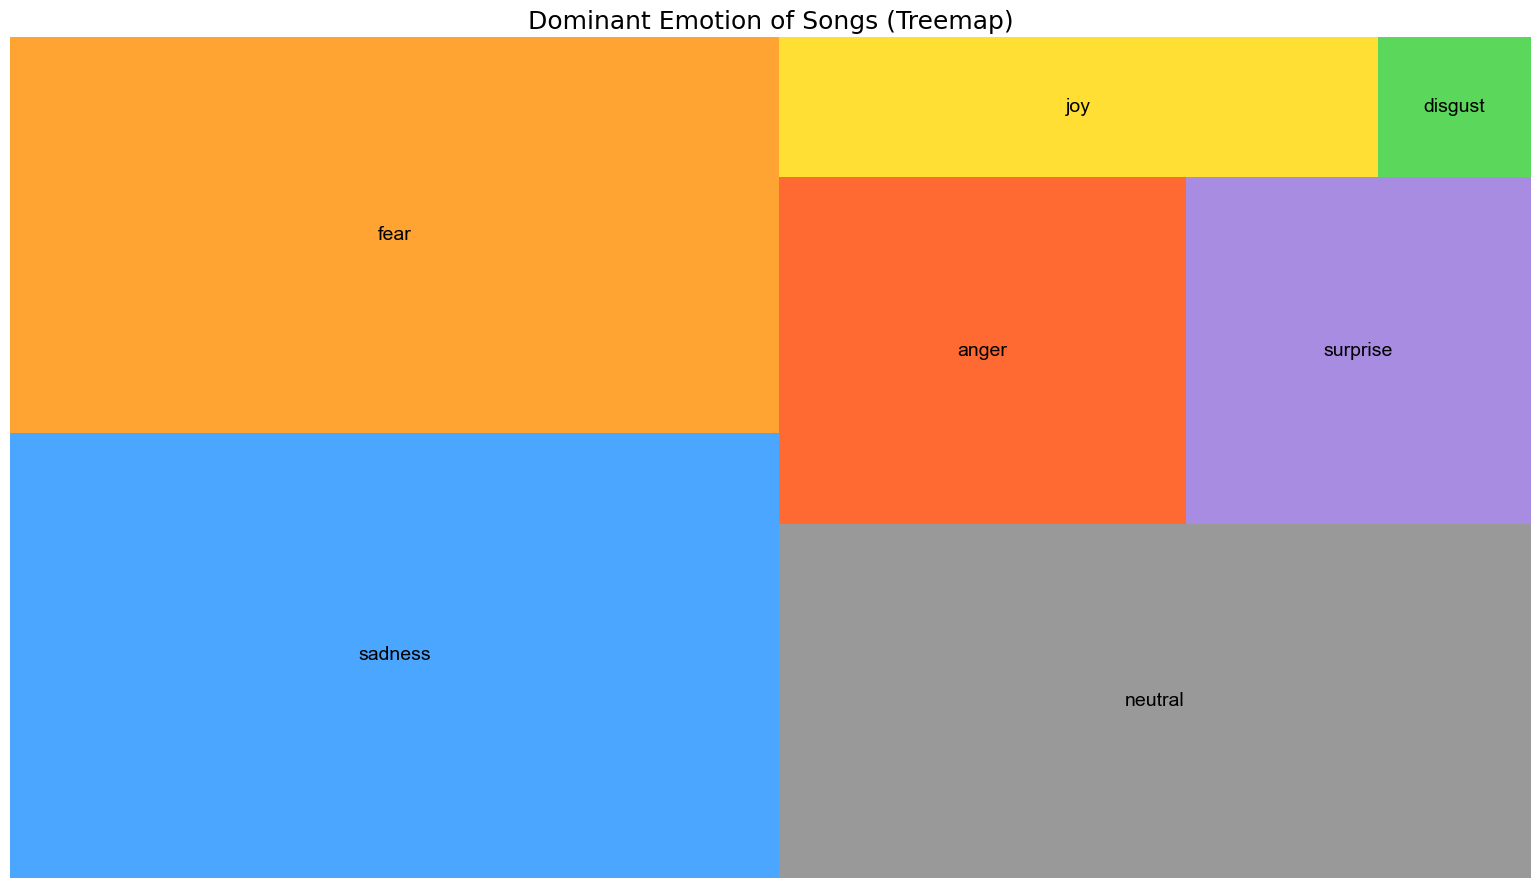

In [32]:
import matplotlib.pyplot as plt
import squarify 

emotion_counts = english_song_lyrics['dominant_emotion'].value_counts()

# color palette for the emotions
emotion_colors = {
    'joy': '#FFD700',
    'neutral': '#808080',
    'surprise': '#9370DB',
    'sadness': '#1E90FF',
    'fear': '#FF8C00',
    'anger': '#FF4500',
    'disgust': '#32CD32'
}

# Get the colors corresponding to the emotions
colors = [emotion_colors[emotion] for emotion in emotion_counts.index]

# Plot the treemap
plt.figure(figsize=(16, 9))
squarify.plot(sizes=emotion_counts, label=emotion_counts.index, color=colors, alpha=0.8, text_kwargs={'fontsize': 14, 'fontname': 'arial'})
plt.tight_layout()
plt.title('Dominant Emotion of Songs (Treemap)', fontsize=18)
plt.axis('off')  # Turn off axis
plt.show()


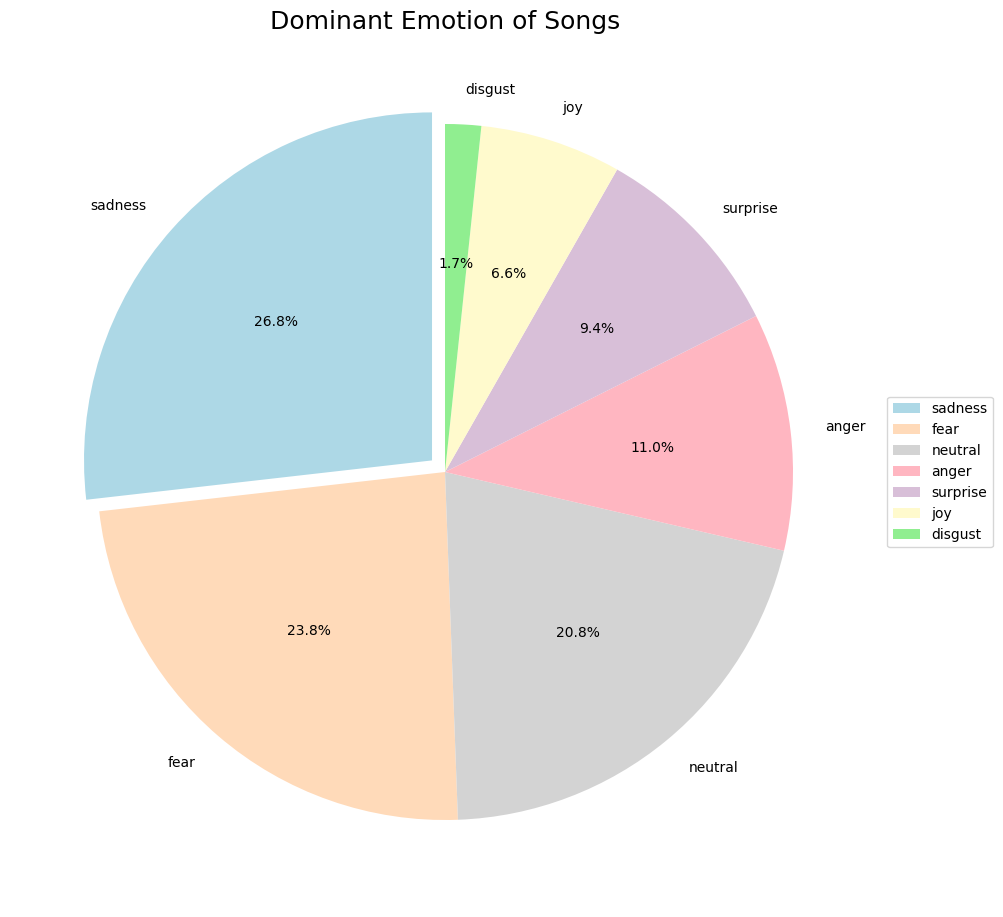

In [35]:
import matplotlib.pyplot as plt

# color palette for the emotions
emotion_colors = {
    'joy': '#FFFACD',       
    'neutral': '#D3D3D3',   
    'surprise': '#D8BFD8',  
    'sadness': '#ADD8E6',   
    'fear': '#FFDAB9',      
    'anger': '#FFB6C1',     
    'disgust': '#90EE90'    
}


# Get the colors corresponding to the emotions
colors = [emotion_colors[emotion] for emotion in emotion_counts.index]

# Create the pie chart
plt.figure(figsize=(16, 9))
plt.pie(
    english_song_lyrics['dominant_emotion'].value_counts(),
    labels=english_song_lyrics['dominant_emotion'].value_counts().index,
    autopct='%1.1f%%',
    startangle=90, 
    colors=colors,  
    explode=(0.05, 0, 0, 0, 0, 0, 0),  # explode the largest slice
)

# put the legend on the right side of the pie chart
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

# Add a title with custom font size and weight
plt.title('Dominant Emotion of Songs', fontsize=18)

# Display the pie chart
plt.show()


## Time to the streaming data into the mix

In [ ]:
# let's load the lyrics_emotion data
lyrics_emotion = pd.read_csv('datasets/lyrics_emotion.csv')
lyrics_emotion = lyrics_emotion[['track_id', 'dominant_emotion']]
print(lyrics_emotion.columns, lyrics_emotion.shape)

Index(['track_id', 'dominant_emotion'], dtype='object') (1858, 2)


In [ ]:
# let's get the streaming data
streaming_data = pd.read_csv('datasets/tracks_df_cleaned.csv')
print(streaming_data.columns, streaming_data.shape)

Index(['ts', 'platform', 'ms_played', 'conn_country', 'track_name',
       'artist_name', 'album_name', 'track_id', 'reason_start', 'reason_end',
       'shuffle', 'skipped', 'offline', 'incognito_mode', 'ts_local', 'hour',
       'day_of_week'],
      dtype='object') (129393, 17)


C:\Users\Kim\AppData\Local\Temp\ipykernel_26216\3297971463.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  streaming_data = pd.read_csv('datasets/tracks_df_cleaned.csv')


In [ ]:
# let's remove the rows that we don't need
streaming_data = streaming_data[['track_id', 'ts', 'ms_played']]
streaming_data.sample(5)

,track_id,ts,ms_played
71710,2BkMrNpLMefSgTsK2HDfig,2020-12-27 00:28:01+00:00,9508
109615,5K2cBicu96Pf4mrBv3Jojk,2023-01-11 10:24:45+00:00,279324
101477,5TIyFlLF0EfYOUZH1TYxBq,2022-08-17 03:00:52+00:00,175693
57093,1vHyZsydQf4h2yDhujnqvQ,2020-03-31 08:12:52+00:00,189476
46151,2Fxmhks0bxGSBdJ92vM42m,2019-06-12 08:55:33+00:00,194087


In [ ]:
# convert the ts_local to datetime format
## I'm going to use 'ts' for now since I couldn't quite figure out how to convert 'ts_local' to datetime format
streaming_data['ts'] = pd.to_datetime(streaming_data['ts'], errors='coerce')

In [ ]:
streaming_data.isna().sum()

track_id     0
ts           0
ms_played    0
dtype: int64

In [ ]:
# let's group the streaming data by daily based on ts_local, and aggregate the data based on its track_id, count its occurence, sum the ms_played
daily_streaming = streaming_data.groupby([streaming_data['ts'].dt.date, 'track_id']).agg(
    ms_played_count = ('ms_played', 'count'),
    ms_played_sum = ('ms_played', 'sum')
).reset_index()


In [ ]:
print(daily_streaming.sample(5))
print(daily_streaming.shape)

               ts                track_id  ms_played_count  ms_played_sum
41920  2022-08-24  2tcnmgYdXZoTpCJGhWFTwf                1          57360
3003   2017-06-03  3HO8tYJGwNdOlctYzGhzkH                1          78720
46315  2023-01-19  6sDeF4lLQHWfGOqBzV3whw                4         510840
51495  2023-05-23  3AlbodF0tKd4Pzhm2wbZdU                3         359316
15819  2019-04-10  2j3g68OQNQKEmQW7kDJeKO                1         166402
(56608, 4)


In [ ]:
# we kinda need the duration of each track, so let's load the track_info
track_info = pd.read_csv('datasets/tracks_info_df.csv')
track_info = track_info[['track_id', 'name', 'artistName', 'duration_ms']].rename(columns={'name':'track_name', 'artistName':'artist_name'})

In [ ]:
# bring the track_info and lyrics emotion together into daily_streaming
daily_streaming = daily_streaming.merge(track_info, on='track_id', how='left')
daily_streaming = daily_streaming.merge(lyrics_emotion, on='track_id', how='right') # thils will only keep the rows that are in lyrics_emotion

In [ ]:
daily_streaming.isna().sum()

ts                  0
track_id            0
ms_played_count     0
ms_played_sum       0
track_name          0
artist_name         0
duration_ms         0
dominant_emotion    0
dtype: int64

In [ ]:
print(daily_streaming.sample(5))
print(daily_streaming.columns, daily_streaming.shape)

               ts                track_id  ms_played_count  ms_played_sum  \
2274   2017-07-16  0afhq8XCExXpqazXczTSve                2         132220   
23261  2022-07-14  1XFxLlYuWdebo6hgczaVDu                2         461193   
31162  2023-04-11  1trLEhC9nDvvj36MfnlwcJ                1         198000   
3028   2019-06-02  3ebXMykcMXOcLeJ9xZ17XH                1         130901   
16768  2022-01-01  4AgHpe2V8ysmdcKw1Q9KNm                2         159467   

                track_name    artist_name  duration_ms dominant_emotion  
2274           Galway Girl     Ed Sheeran       170826              joy  
23261           Pretending  Orla Gartland       215694          sadness  
31162          Someone New         Laufey       198000             fear  
3028   Scared to Be Lonely  Martin Garrix       220883             fear  
16768      Goodbye Forever     Us The Duo       158777          sadness  
Index(['ts', 'track_id', 'ms_played_count', 'ms_played_sum', 'track_name',
       'artist_nam

In [ ]:
# since this dataframe will be used multiple times, let's save it into a new csv file
daily_streaming.to_csv('datasets/daily_streaming_emotion.csv', index=False)

### Top 5 most played track per emotion category

In [ ]:
daily_streaming = pd.read_csv('datasets/daily_streaming_emotion.csv')
print(daily_streaming.head(5))
print(daily_streaming.columns, daily_streaming.shape)

           ts                track_id  ms_played_count  ms_played_sum  \
0  2016-05-14  4mjgNE8R31AzxWfPNGtVMf                1           5614   
1  2016-05-14  6jvMmRtSzoEibQGrQkSISQ                1           3677   
2  2016-05-14  4VrdksXJVhAOLW49qV0VTQ                1           2971   
3  2016-10-29  05LCfd8s9n2teUcsTsBAnr                1         123706   
4  2016-10-29  2kBR8dkyKfd25W9PRUFrLh                1          24572   

                                  track_name     artist_name  duration_ms  \
0                   Best of 2015 (Album Mix)      Monstercat      9158194   
1                    Monstercat Best of 2012      Monstercat      6348017   
2          Best of 2014 (Album Mix - Part 1)      Monstercat      3374468   
3                                    Alladat   Jarren Benton       207560   
4  Don't Get It Misunderstood (feat. Venice)  Kyle Coglitore       139702   

  dominant_emotion  
0             fear  
1          neutral  
2          sadness  
3            a

In [ ]:
track_stream = daily_streaming.groupby('track_id').agg(
    artist_name = ('artist_name', 'first'),
    track_name = ('track_name', 'first'),
    duration_ms = ('duration_ms', 'first'),
    ms_played_sum = ('ms_played_sum', 'sum'),
    dominant_emotion = ('dominant_emotion', 'first')
).reset_index()

In [ ]:
# calculate the total track played in minutes
track_stream['m_played_sum'] = track_stream['ms_played_sum'] / 60000

In [ ]:
col_order = ['artist_name', 'track_name', 'duration_ms', 'ms_played_sum', 'm_played_sum', 'dominant_emotion']

In [ ]:
# show top 10 tracks with the most ms_played_sum on each dominant_emotion categories
for emotion in track_stream['dominant_emotion'].unique():
    print(emotion)
    display(track_stream[track_stream['dominant_emotion'] == emotion][col_order].sort_values('ms_played_sum', ascending=False).head(5))

anger


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion
1723,Florence + The Machine,Kiss With a Fist,134613,88771450,1479.524167,anger
561,Billie Eilish,bad guy,194087,74409137,1240.152283,anger
702,Bishop Briggs,White Flag,230586,66187218,1103.120300,anger
269,Daniela Andrade,Take Care,231000,58893736,981.562267,anger
132,dodie,Hot Mess,174558,50551136,842.518933,anger


neutral


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion
1844,Foster The People,Pumped Up Kicks,239600,120515665,2008.594417,neutral
1314,In Love With a Ghost,Flowers,252121,86496943,1441.615717,neutral
867,All Sons & Daughters,Wake Up,396453,68912653,1148.544217,neutral
1514,Us The Duo,La La La,192248,64863262,1081.054367,neutral
487,Killabyte,Wicked Ways,254896,59749632,995.827200,neutral


surprise


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion
86,Daniela Andrade,Falling in Love at a Coffee Shop,226500,72667927,1211.132117,surprise
1634,Virtual Riot,Time Stops,276374,71865120,1197.752000,surprise
243,Orla Gartland,Why Am I Like This?,212713,68866395,1147.773250,surprise
1007,Daniela Andrade,Crazy,242000,68299706,1138.328433,surprise
1619,Daniela Andrade,Crazy in Love,227500,56354282,939.238033,surprise


joy


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion
1552,St. Vincent,Fast Slow Disco,197005,62933152,1048.885867,joy
604,Electric Light Orchestra,Mr. Blue Sky,303373,60192265,1003.204417,joy
1108,dark cat,BUBBLE TEA,243375,59752553,995.875883,joy
477,Pomplamoose,"Harder, Better, Faster, Stronger",248498,56588267,943.137783,joy
306,Pomplamoose,Mr. Blue Sky,279137,54702227,911.703783,joy


sadness


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion
1354,Darren Korb,Good Riddance (Eurydice Solo),177322,107982423,1799.707050,sadness
901,Bishop Briggs,Dream,194960,93539401,1558.990017,sadness
884,dodie,Would You Be So Kind,180952,85727026,1428.783767,sadness
117,Fight Like Apes,I'm Beginning To Think You Prefer Beverly Hill...,203413,73306970,1221.782833,sadness
794,Direct,Oracle Heart,275014,66780698,1113.011633,sadness


disgust


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion
949,dodie,Got Weird,202435,73097720,1218.295333,disgust
997,dodie,She,213611,53760898,896.014967,disgust
519,Bishop Briggs,Baby,194000,44018418,733.640300,disgust
1425,In Love With a Ghost,I Don't Know and I Don't Want to Know,186000,24734593,412.243217,disgust
1270,dodie,If I'm Being Honest,279324,15410967,256.849450,disgust


fear


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion
925,Bishop Briggs,River,216133,117187842,1953.130700,fear
919,Bishop Briggs,Tempt My Trouble,193986,97831472,1630.524533,fear
1602,Lorde,Green Light,234652,67806723,1130.112050,fear
756,Burbank,"Sorry, I Like You",122790,58917172,981.952867,fear
658,Tessa Violet,Interlude III,169723,56989968,949.832800,fear


In [ ]:
# let's bring back the lyrics_emotion data to get the detailed emotion scores
lyrics_emotion = pd.read_csv('datasets/lyrics_emotion.csv')

# get the emotion scores from lyrics_emotion
emotion_scores = ['anger', 'joy', 'disgust', 'sadness', 'surprise', 'fear', 'neutral']
lyrics_emotion = lyrics_emotion[['track_id'] + emotion_scores]
track_stream_w_emotion_score = track_stream.merge(lyrics_emotion, on='track_id', how='left')

In [ ]:
track_stream_w_emotion_score['m_played_sum'].describe()

count    1858.000000
mean      109.727402
std       233.433357
min         0.000000
25%         2.328621
50%         4.846175
75%        95.723708
max      2008.594417
Name: m_played_sum, dtype: float64

In [ ]:
# show top 10 tracks with the most ms_played_sum on each dominant_emotion categories
for emotion in track_stream['dominant_emotion'].unique():
    print(emotion)
    display(track_stream_w_emotion_score[(track_stream['dominant_emotion'] == emotion) 
                                         & (track_stream_w_emotion_score['m_played_sum'] > 100)] \
                                            [col_order + emotion_scores].sort_values(emotion, ascending=False).head(5))

anger


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion,anger,joy,disgust,sadness,surprise,fear,neutral
1688,Darren Korb,Hymn to Zagreus,164117,7331764,122.196067,anger,0.955437,0.001504,0.016262,0.006589,0.001928,0.011572,0.006709
978,Wasia Project,Burning Eyes R Calling,313491,22828688,380.478133,anger,0.932614,0.002243,0.016820,0.031547,0.001884,0.004076,0.010817
1854,Wasia Project,Burning Eyes R Calling,313539,21190285,353.171417,anger,0.932614,0.002243,0.016820,0.031547,0.001884,0.004076,0.010817
646,Gorillaz,Dirty Harry,230426,28561693,476.028217,anger,0.900115,0.004712,0.014777,0.032569,0.003804,0.011370,0.032654
1807,Aimer,Through My Blood <AM>,241533,16454255,274.237583,anger,0.895902,0.001826,0.012829,0.013730,0.012677,0.028800,0.034236


neutral


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion,anger,joy,disgust,sadness,surprise,fear,neutral
1794,Aron Wright,Build It Better,234473,35579314,592.988567,neutral,0.024841,0.023292,0.009853,0.017533,0.041169,0.002720,0.880592
606,"quickly, quickly",Getsomerest/sleepwell,332173,19137356,318.955933,neutral,0.021884,0.001964,0.053298,0.009874,0.083534,0.012072,0.817374
1779,audalanche,Find the Light (feat. Harley Holmes),183774,19393695,323.228250,neutral,0.016701,0.101925,0.003388,0.033300,0.047893,0.021326,0.775468
867,All Sons & Daughters,Wake Up,396453,68912653,1148.544217,neutral,0.034940,0.041509,0.018097,0.068278,0.036876,0.034006,0.766293
1661,THREE1989,UNIVERSE,253826,16386111,273.101850,neutral,0.039096,0.081321,0.008492,0.018795,0.069564,0.020769,0.761963


surprise


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion,anger,joy,disgust,sadness,surprise,fear,neutral
141,Wasia Project,My Lover Is Sleeping,226505,7411063,123.517717,surprise,0.012938,0.002446,0.013903,0.017418,0.901818,0.029288,0.022189
178,Kurt Hugo Schneider,Maps,198500,16669017,277.816950,surprise,0.012077,0.002348,0.010438,0.021481,0.889669,0.047756,0.016230
1206,Tut Tut Child,Breathe (feat. Danyka Nadeau),275121,27107682,451.794700,surprise,0.013607,0.003473,0.005737,0.022401,0.878219,0.046486,0.030077
1213,Matilda Mann,Bloom,166053,6356168,105.936133,surprise,0.017162,0.007625,0.005902,0.014999,0.876276,0.014838,0.063198
500,dodie,Ready Now,181969,12857877,214.297950,surprise,0.008543,0.031594,0.007268,0.007448,0.859447,0.007189,0.078511


joy


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion,anger,joy,disgust,sadness,surprise,fear,neutral
1337,The Polyphonic Spree,It's the Sun,334599,9265080,154.41800,joy,0.005864,0.918943,0.002661,0.016786,0.009471,0.000792,0.045482
636,Us The Duo,Winter Wonderland,162277,8891166,148.18610,joy,0.009487,0.912766,0.000754,0.011870,0.015367,0.021778,0.027977
313,Toploader,Dancing in the Moonlight,233373,19255797,320.92995,joy,0.002923,0.908183,0.004133,0.007507,0.005319,0.004734,0.067201
605,Ed Sheeran,Happier,207520,25473594,424.55990,joy,0.007935,0.770841,0.005054,0.070808,0.040787,0.001675,0.102900
782,Us The Duo,Every Day Is Ours,268022,31563669,526.06115,joy,0.006939,0.766884,0.004249,0.043271,0.007606,0.008357,0.162695


sadness


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion,anger,joy,disgust,sadness,surprise,fear,neutral
1840,Rook1e,Alone Together,108975,7069693,117.828217,sadness,0.001092,0.002091,0.001474,0.977441,0.006089,0.001779,0.010034
87,Us The Duo,Already Mine,273126,22540038,375.667300,sadness,0.002508,0.001481,0.001494,0.977299,0.003772,0.004998,0.008448
1109,Us The Duo,Heartbreak,296546,21129981,352.166350,sadness,0.001336,0.003124,0.001001,0.976645,0.007521,0.001243,0.009130
1442,Lawrence,Homesick,198026,7320834,122.013900,sadness,0.001540,0.005048,0.001054,0.974872,0.006056,0.003253,0.008178
1208,Us The Duo,Missin' You Like Crazy,206146,26413690,440.228167,sadness,0.001839,0.002357,0.001712,0.974601,0.005153,0.003040,0.011297


disgust


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion,anger,joy,disgust,sadness,surprise,fear,neutral
949,dodie,Got Weird,202435,73097720,1218.295333,disgust,0.225963,0.016657,0.515168,0.033031,0.075585,0.082836,0.050760
1487,The 1975,Sincerity Is Scary,225955,14490717,241.511950,disgust,0.375960,0.003132,0.455613,0.027877,0.050872,0.017852,0.068695
997,dodie,She,213611,53760898,896.014967,disgust,0.012341,0.020367,0.414626,0.124669,0.048235,0.027690,0.352073
519,Bishop Briggs,Baby,194000,44018418,733.640300,disgust,0.183851,0.022472,0.414070,0.037737,0.042646,0.040944,0.258280
691,Lawrence,Superficial,248026,9514963,158.582717,disgust,0.292504,0.010894,0.341404,0.149321,0.088281,0.019587,0.098008


fear


,artist_name,track_name,duration_ms,ms_played_sum,m_played_sum,dominant_emotion,anger,joy,disgust,sadness,surprise,fear,neutral
756,Burbank,"Sorry, I Like You",122790,58917172,981.952867,fear,0.001008,0.000960,0.000303,0.001231,0.001442,0.994158,0.000897
512,Au5,Inside (feat. Danyka Nadeau),289970,15922561,265.376017,fear,0.001293,0.000802,0.000444,0.002299,0.000745,0.993006,0.001410
495,THREE1989,High Times,226746,16596883,276.614717,fear,0.002145,0.003004,0.000794,0.003624,0.002672,0.979036,0.008724
1011,Daisy the Great,IDKW,105897,6553396,109.223267,fear,0.011395,0.001350,0.001086,0.003025,0.005019,0.976251,0.001876
347,Us The Duo,Right Where I Should Be,195557,17712020,295.200333,fear,0.002338,0.006420,0.000693,0.004716,0.010645,0.968153,0.007034


### streamed track emotions per month

In [ ]:
aggregated_data = daily_streaming.groupby('ts').agg(
    total_ms_played_sum=('ms_played_sum', 'sum')
).reset_index()

In [ ]:
print(aggregated_data.head(5))
print(aggregated_data.columns, aggregated_data.shape)

           ts  total_ms_played_sum
0  2016-05-14                12262
1  2016-10-29              1709993
2  2016-11-01              4833424
3  2016-11-02             17943680
4  2016-11-03             11780356
Index(['ts', 'total_ms_played_sum'], dtype='object') (1989, 2)


In [ ]:
daily_streaming['dominant_emotion'].unique()

array(['fear', 'neutral', 'sadness', 'anger', 'surprise', 'joy',
       'disgust'], dtype=object)

In [ ]:
# Aggregate ms_played_sum for each emotion category
for emotion in daily_streaming['dominant_emotion'].unique():
    emotion_sum = daily_streaming[daily_streaming['dominant_emotion'] == emotion].groupby('ts')['ms_played_sum'].sum().reset_index()
    emotion_sum = emotion_sum.rename(columns={'ms_played_sum': f'{emotion}_ms_played_sum'})
    
    # put the emotion_sum into aggregated_data
    aggregated_data = aggregated_data.merge(emotion_sum, on='ts', how='left')

# in case there are NaN values
aggregated_data = aggregated_data.fillna(0)


In [ ]:
aggregated_data.head(5)

,ts,total_ms_played_sum,fear_ms_played_sum,neutral_ms_played_sum,sadness_ms_played_sum,anger_ms_played_sum,surprise_ms_played_sum,joy_ms_played_sum,disgust_ms_played_sum
0,2016-05-14,12262,5614.0,3677.0,2971.0,0.0,0.0,0.0,0.0
1,2016-10-29,1709993,262875.0,453892.0,706636.0,148640.0,137950.0,0.0,0.0
2,2016-11-01,4833424,414226.0,1154496.0,1239593.0,913602.0,1111507.0,0.0,0.0
3,2016-11-02,17943680,529177.0,11003104.0,3330799.0,1424862.0,1655738.0,0.0,0.0
4,2016-11-03,11780356,523307.0,1189454.0,1123491.0,1783024.0,7161080.0,0.0,0.0


In [ ]:
# since there are some missing dates, let's fill the missing dates with 0
# convert ts to datetime format
aggregated_data['ts'] = pd.to_datetime(aggregated_data['ts'])

# create the date range based on ts's min and max and create a dataframe
date_range = pd.date_range(aggregated_data['ts'].min(), aggregated_data['ts'].max())
date_range_df = pd.DataFrame(date_range, columns=['ts'])

# merge the date_range_df with aggregated_data and fill the empties
complete_date_data = date_range_df.merge(aggregated_data, on='ts', how='left')
complete_date_data = complete_date_data.fillna(0)

In [ ]:
print(complete_date_data.head(5))
print(complete_date_data.columns, complete_date_data.shape)

          ts  total_ms_played_sum  fear_ms_played_sum  neutral_ms_played_sum  \
0 2016-05-14              12262.0              5614.0                 3677.0   
1 2016-05-15                  0.0                 0.0                    0.0   
2 2016-05-16                  0.0                 0.0                    0.0   
3 2016-05-17                  0.0                 0.0                    0.0   
4 2016-05-18                  0.0                 0.0                    0.0   

   sadness_ms_played_sum  anger_ms_played_sum  surprise_ms_played_sum  \
0                 2971.0                  0.0                     0.0   
1                    0.0                  0.0                     0.0   
2                    0.0                  0.0                     0.0   
3                    0.0                  0.0                     0.0   
4                    0.0                  0.0                     0.0   

   joy_ms_played_sum  disgust_ms_played_sum  
0                0.0              

In [ ]:
monthly_data = complete_date_data.set_index('ts').resample('ME').sum().reset_index()

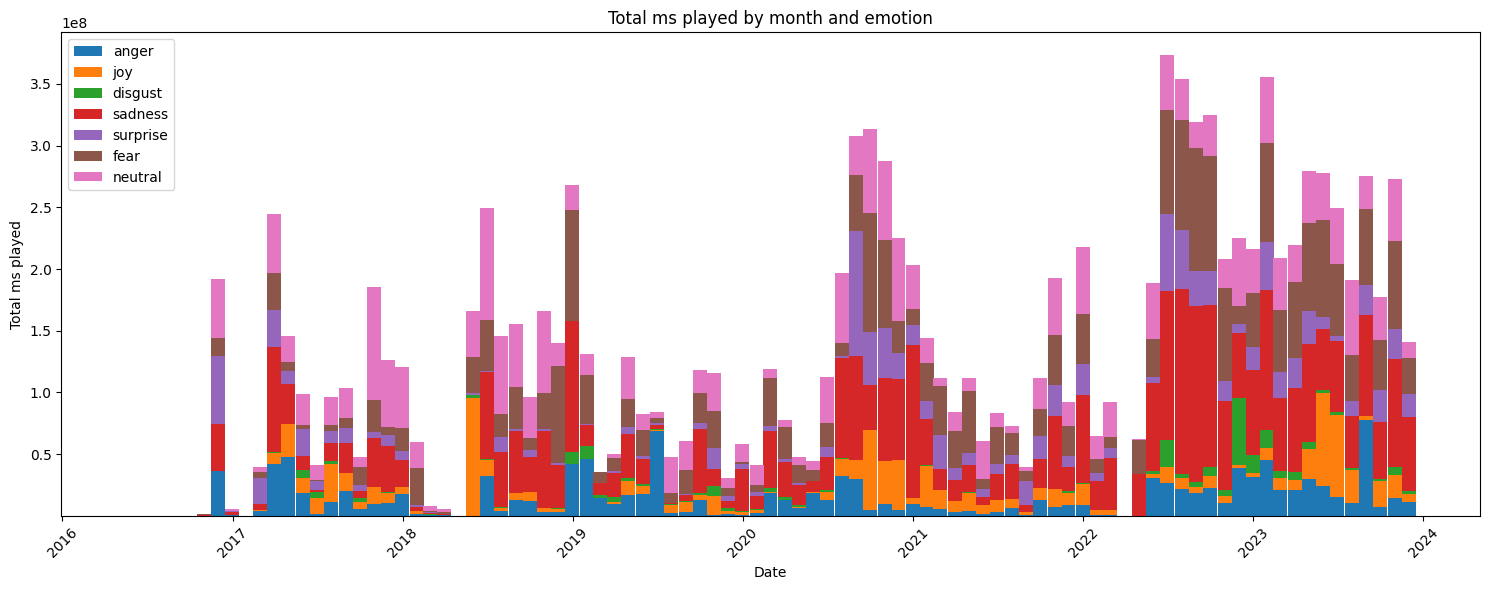

In [ ]:
# Set up the figure size
plt.figure(figsize=(15, 6))

# Set bar width
bar_width = 30  # Adjust bar width

# set the bottom values
bottom_values = np.zeros(len(monthly_data))

# Loop through each emotion and create stacked bars
for emotion in ['anger', 'joy', 'disgust', 'sadness', 'surprise', 'fear', 'neutral']: # so we have consistent order
    emotion_column = f'{emotion}_ms_played_sum'
    plt.bar(monthly_data['ts'], monthly_data[emotion_column], width=bar_width, label=emotion, bottom=bottom_values)
    bottom_values += monthly_data[emotion_column]

# Plot the total ms_played_sum as a line
# plt.plot(monthly_data['ts'], monthly_data['total_ms_played_sum'], label='Total', color='black', linewidth=2, marker='o')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Total ms played')
plt.title('Total ms played by month and emotion')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout for better fitting
plt.show()


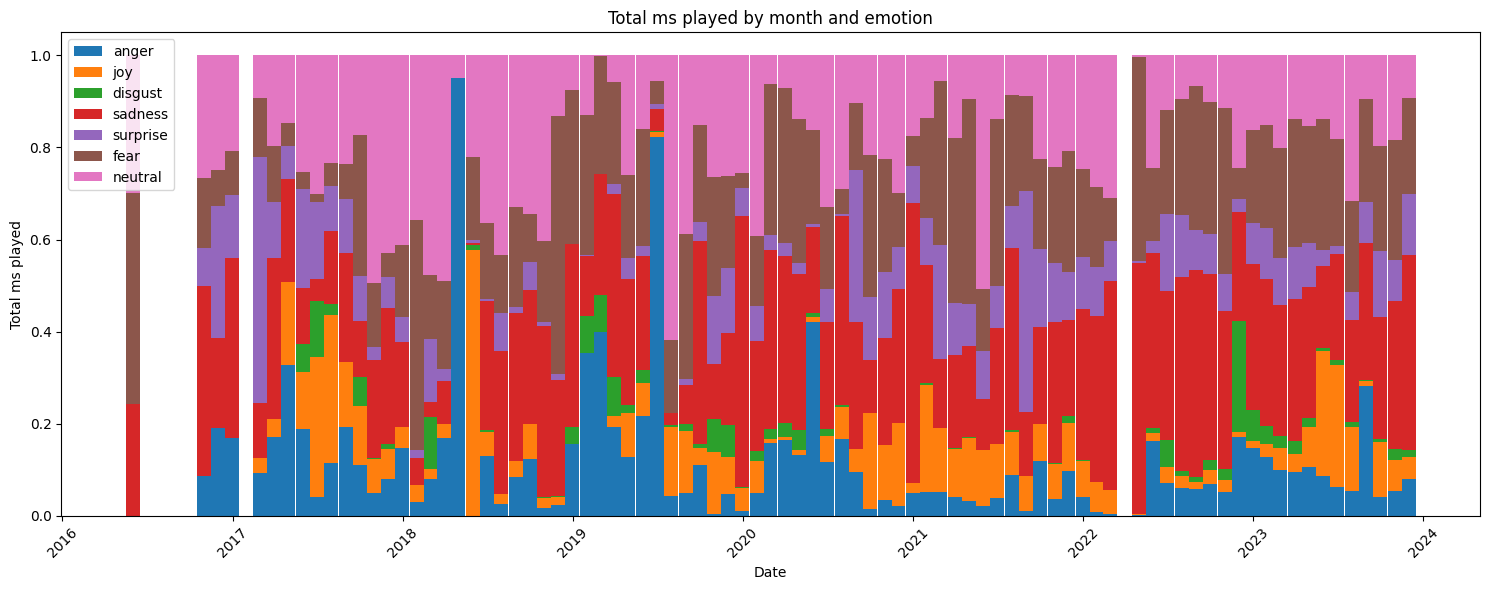

In [ ]:
## plot as percentage
# Set up the figure size
plt.figure(figsize=(15, 6))

# Set bar width
bar_width = 30  # Adjust bar width

# set the bottom values
bottom_values = np.zeros(len(monthly_data))

# Loop through each emotion and create stacked bars
for emotion in ['anger', 'joy', 'disgust', 'sadness', 'surprise', 'fear', 'neutral']: # so we have consistent order
    emotion_column = f'{emotion}_ms_played_sum'
    plt.bar(monthly_data['ts'], monthly_data[emotion_column] / monthly_data['total_ms_played_sum'], width=bar_width, label=emotion, bottom=bottom_values)
    bottom_values += monthly_data[emotion_column] / monthly_data['total_ms_played_sum']

# Plot the total ms_played_sum as a line
# plt.plot(monthly_data['ts'], monthly_data['total_ms_played_sum'], label='Total', color='black', linewidth=2, marker='o')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Total ms played')
plt.title('Total ms played by month and emotion')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout for better fitting
plt.show()


### what's the most dominant emotion on each month?

In [ ]:
# Determine the most dominant emotion of each month
# Use idxmax to find the index of the maximum value in the emotion columns
dominant_emotion_indices = monthly_data[['anger_ms_played_sum', 'joy_ms_played_sum', 
                                          'disgust_ms_played_sum', 'sadness_ms_played_sum', 
                                          'surprise_ms_played_sum', 'fear_ms_played_sum', 
                                          'neutral_ms_played_sum']].idxmax(axis=1)

# Check if all emotions are zero and assign 'none' if true
monthly_data['dominant_emotion'] = np.where(
    monthly_data[['anger_ms_played_sum', 'joy_ms_played_sum', 'disgust_ms_played_sum', 
                   'sadness_ms_played_sum', 'surprise_ms_played_sum', 'fear_ms_played_sum', 
                   'neutral_ms_played_sum']].sum(axis=1) == 0, 
    'none', 
    dominant_emotion_indices
)

# Remove the suffix to get just the emotion name
monthly_data['dominant_emotion'] = monthly_data['dominant_emotion'].str.replace('_ms_played_sum', '')

# Create a new column for the dominant emotion's playtime
monthly_data['dominant_emotion_played'] = monthly_data.apply(
    lambda row: row[f"{row['dominant_emotion']}_ms_played_sum"] if row['dominant_emotion'] != 'none' else 0, 
    axis=1
)

# convert into minutes
monthly_data['dominant_emotion_played'] = monthly_data['dominant_emotion_played'] / 60000
monthly_data['total_m_played_sum'] = monthly_data['total_ms_played_sum'] / 60000

# Select relevant columns to display
monthly_dominant_emotion = monthly_data[['ts', 'total_m_played_sum', 'dominant_emotion', 'dominant_emotion_played']]

# Display the result
print(monthly_dominant_emotion)

           ts  total_m_played_sum dominant_emotion  dominant_emotion_played
0  2016-05-31            0.204367             fear                 0.093567
1  2016-06-30            0.000000             none                 0.000000
2  2016-07-31            0.000000             none                 0.000000
3  2016-08-31            0.000000             none                 0.000000
4  2016-09-30            0.000000             none                 0.000000
5  2016-10-31           28.499883          sadness                11.777267
6  2016-11-30         3201.736567         surprise               919.486933
7  2016-12-31           91.513383          sadness                35.862317
8  2017-01-31            0.000000             none                 0.000000
9  2017-02-28          657.367517         surprise               351.241267
10 2017-03-31         4077.051783          sadness              1429.832283
11 2017-04-30         2434.795033            anger               796.286033
12 2017-05-3

### dominant emotions ordered from the highest

In [ ]:
monthly_dominant_emotion['dominant_emotion'].value_counts()

dominant_emotion
sadness     34
neutral     23
fear        14
none         6
anger        6
surprise     4
joy          4
Name: count, dtype: int64

In [ ]:
# print the dominant emotion of all months from the result (highest to lowest)
monthly_dominant_emotion.groupby('dominant_emotion')['dominant_emotion_played'].sum().sort_values(ascending=False)

dominant_emotion
sadness     36760.598067
neutral     15708.153783
fear        10648.003767
joy          3425.321283
anger        3275.246783
surprise     3274.674583
none            0.000000
Name: dominant_emotion_played, dtype: float64